In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np

from mvpa2.suite import SimpleSOMMapper
import cartopy.crs as ccrs

import xarray as xr
from xarray.core.common import _full_like as full_like

In [2]:
# projection class
class Rasm(ccrs.Projection):

    def __init__(self):

        proj4_params = {'R': 6371200.0,
                        'lat_0': 90.0,
                        'lat_1': 90,
                        'lat_2': 90,
                        'lon_0': -114.0+360,
                        'proj': 'lcc',
                        'units': 'm',
                        'x_0': 9469302.950316086,
                        'y_0': 6201952.603370549}

        super(Rasm, self).__init__(proj4_params)

    @property
    def boundary(self):
        coords = ((self.x_limits[0], self.y_limits[0]),(self.x_limits[1], self.y_limits[0]),
                  (self.x_limits[1], self.y_limits[1]),(self.x_limits[0], self.y_limits[1]),
                  (self.x_limits[0], self.y_limits[0]))

        return ccrs.sgeom.Polygon(coords).exterior

    @property
    def threshold(self):
        return 100000.0

    @property
    def x_limits(self):
        return (0, 16423961.103252266)

    @property
    def y_limits(self):
        return (0, 12228062.194885937)

In [3]:
ncfiles = {}
# Grid and domain files
ncfiles['rasm_domain'] = '/raid2/jhamman/projects/RASM/data/inputdata/CESM/share/domains/domain.lnd.wr50a_ar9v4.100920.nc'
ncfiles['$RASM_{CONTROL}$'] = '/raid2/jhamman/projects/RASM/data/processed/R1010RBRbaaa01a/cpl/monthly_mean_timeseries/R1010RBRbaaa01a.cpl.hmm.197909-201412.nc'


ncdata = {}
for k, v in ncfiles.items():
    ncdata[k] = xr.open_dataset(v)
    
ncdata['$RASM_{CONTROL}$'] = ncdata['$RASM_{CONTROL}$'].rename({'a2xavg_nx': 'ni',
 'a2xavg_ny': 'nj',
 'l2xavg_nx': 'ni',
 'l2xavg_ny': 'nj',
 'x2aavg_nx': 'ni',
 'x2aavg_ny': 'nj',
 'x2lavg_nx': 'ni',
 'x2lavg_ny': 'nj'})

In [4]:
ncdata['$RASM_{CONTROL}$'].coords['xc'] = ncdata['rasm_domain']['xc']
ncdata['$RASM_{CONTROL}$'].coords['yc'] = ncdata['rasm_domain']['yc']
for v in ['mask', 'frac', 'area']:
    ncdata['$RASM_{CONTROL}$'][v] = ncdata['rasm_domain'][v]
ncdata['$RASM_{CONTROL}$']


<xarray.Dataset>
Dimensions:             (ni: 275, nj: 205, time: 424)
Coordinates:
  * time                (time) datetime64[ns] 1979-09-16 1979-10-16T12:00:00 ...
  * nj                  (nj) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * ni                  (ni) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    yc                  (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 ...
    xc                  (nj, ni) float64 189.2 189.4 189.6 189.7 189.9 190.1 ...
Data variables:
    x2aavg_Faxx_evap    (time, nj, ni) float64 -1.511e-05 -2.826e-05 ...
    a2xavg_Sa_tbot      (time, nj, ni) float64 300.6 300.6 300.6 300.6 300.6 ...
    a2xavg_Faxa_rainc   (time, nj, ni) float64 8.919e-05 8.891e-05 5.947e-05 ...
    a2xavg_Faxa_rainl   (time, nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    a2xavg_Faxa_snowc   (time, nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    a2xavg_Faxa_snowl   (time, nj, ni) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    l2xavg_Sl_avsdr     (

In [5]:
total_precip = (ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_rainc +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_rainl +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_snowc +
                ncdata['$RASM_{CONTROL}$'].a2xavg_Faxa_snowl)

In [6]:
def anomalies(da, by='time.month', dim='time', standardize=True):
    g = da.groupby(by)
    climatology = g.mean(dim)

    anomalies = (g - climatology)
    if standardize:
        std = g.std(dim)
        anomalies = anomalies.groupby(by) / std
    
    return anomalies

In [7]:
precip_anoms = anomalies(total_precip, standardize=True)
evap_anoms = anomalies(ncdata['$RASM_{CONTROL}$'].x2aavg_Faxx_evap, standardize=True)

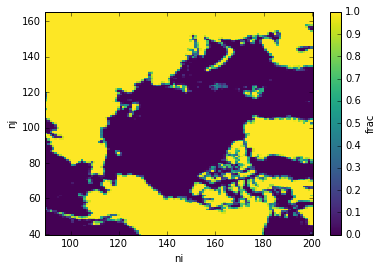

In [8]:
ni_slice = slice(90, 275-75)
nj_slice = slice(40, 205-40)

ncdata['$RASM_{CONTROL}$']['frac'].sel(ni=ni_slice, nj=nj_slice).plot()

In [9]:
# data = precip_anoms.sel(time=precip_anoms.indexes['time'].month > 9).values
data = precip_anoms.sel(time=precip_anoms.indexes['time'].month > 9,
                        ni=ni_slice, nj=nj_slice)
ntime, ny, nx = data.shape
nspace = ny * nx

# dummy data
# nx = 275 # 275
# ny = 205 # 205
# nspace = ny*nx
# ntime = 3*35
# data = np.random.random(size=(ntime, ny, nx))

print(data.shape)
dr = data.values.reshape(ntime, nspace)
print(dr.shape)
som_shape = (3, 3)

(108, 126, 111)
(108, 13986)


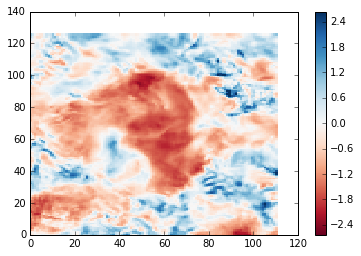

In [10]:
plt.pcolormesh(data[4], cmap='RdBu', vmin=data.max()*-0.5, vmax=data.max()*0.5)
plt.colorbar()

In [11]:
som = SimpleSOMMapper(som_shape, 500)
som

SimpleSOMMapper(kshape=(3, 3), niter=500, learning_rate=0.005000, iradius=3.000000)

In [12]:
%time som.train(dr)

CPU times: user 54 s, sys: 0 ns, total: 54 s
Wall time: 54 s


In [13]:
# This gives us the location of each timestep in the SOM
som_inds = [tuple(si) for si in som.forward(dr)]

In [14]:
for i in set(som_inds):
    print(i, float(som_inds.count(i)) / len(som_inds) * 100)

((0, 1), 9.25925925925926)
((1, 2), 3.7037037037037033)
((0, 0), 13.88888888888889)
((2, 1), 11.11111111111111)
((1, 1), 13.88888888888889)
((2, 0), 1.8518518518518516)
((2, 2), 16.666666666666664)
((1, 0), 14.814814814814813)
((0, 2), 14.814814814814813)


In [15]:
k_da = xr.DataArray(som.K.reshape(som_shape + (ny, nx)), dims=('som_y', 'som_x') + precip_anoms.dims[1:])
k_da.coords['ni'] = data.coords['ni']
k_da.coords['nj'] = data.coords['nj']
k_da.coords['xc'] = data.coords['xc']
k_da.coords['yc'] = data.coords['yc']

In [16]:
data.coords['xc']

<xarray.DataArray 'xc' (nj: 126, ni: 111)>
array([[ 199.03527957,  199.45904665,  199.88955813, ...,  278.2368323 ,
         278.87814394,  279.51030794],
       [ 198.58163577,  199.00494509,  199.4350751 , ...,  278.64878908,
         279.29433504,  279.93046632],
       [ 198.12129337,  198.54402286,  198.97364932, ...,  279.07020632,
         279.71994081,  280.35998597],
       ..., 
       [ 114.78813082,  114.36686618,  113.93852146, ...,   32.08707403,
          31.42939734,   30.78194785],
       [ 114.31458957,  113.89251621,  113.4634238 , ...,   32.52759145,
          31.87399649,   31.23033881],
       [ 113.84791477,  113.4251395 ,  112.99545201, ...,   32.9580953 ,
          32.30863928,   31.66884589]])
Coordinates:
  * nj       (nj) int64 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 ...
  * ni       (ni) int64 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 ...
    yc       (nj, ni) float64 49.64 49.93 50.22 50.51 50.8 51.08 51.36 51.64 ...
    xc       (nj, ni

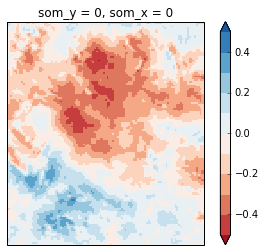

In [17]:
plt.subplots(1, 1, subplot_kw=dict(projection=Rasm()))

m = k_da[dict(som_x=0, som_y=0)].plot.pcolormesh('xc', 'yc', cmap='RdBu', robust=True, extend='both', levels=11,
                            transform=ccrs.PlateCarree())

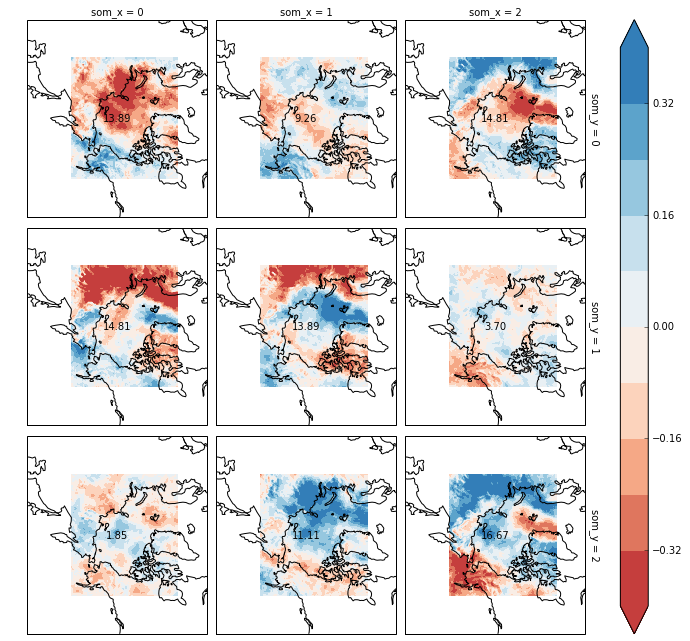

In [18]:
fg = k_da.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu', robust=True, extend='both', levels=11,
                          subplot_kws=dict(projection=Rasm()),
                          transform=ccrs.PlateCarree())

for i in set(som_inds):
#     print(i, float(som_inds.count(i)) / len(som_inds) * 100)
          
    fg.axes[i].text(0.5, 0.5,'{:.2f}'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    
    fg.axes[i].coastlines()
#     fg.axes[i].set_extent([0, 360, 50, 90], crs=ccrs.PlateCarree())

In [19]:
evap_anoms = evap_anoms.sel(time=evap_anoms.indexes['time'].month > 9, ni=ni_slice, nj=nj_slice)

In [20]:
evap_mapped_som = full_like(k_da, fill_value=np.nan)

In [21]:
for i in set(som_inds):
    bool_mask = [i == si for si in som_inds]
    evap_mapped_som[dict(som_y=i[0], som_x=i[1])] = evap_anoms.values[np.nonzero(bool_mask)[0]].mean(axis=0)

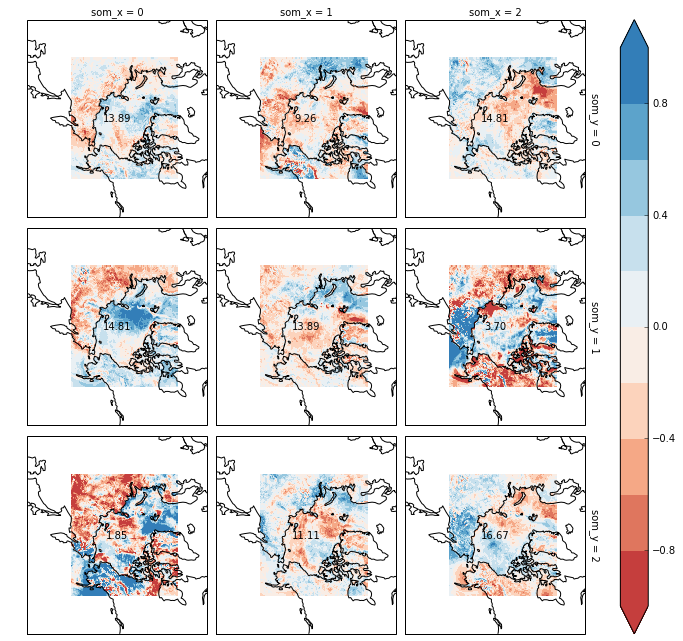

In [22]:
fg = evap_mapped_som.plot.pcolormesh('xc', 'yc', row='som_y', col='som_x', cmap='RdBu', robust=True, extend='both', levels=11,
                          subplot_kws=dict(projection=Rasm()),
                          transform=ccrs.PlateCarree())

for i in set(som_inds):
#     print(i, float(som_inds.count(i)) / len(som_inds) * 100)
          
    fg.axes[i].text(0.5, 0.5,'{:.2f}'.format(float(som_inds.count(i)) / float(len(som_inds)) * 100),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = fg.axes[i].transAxes)
    fg.axes[i].coastlines()


In [ ]:
len(bool_mask)

In [ ]:
np.sum(bool_mask)

In [ ]:
ax = fg.axes[i]